<a href="https://colab.research.google.com/github/YaninaK/sales-forecast/blob/main/notebooks/03_Baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales forecast for 20 stores for for 31 days' period.

## Baseline model - Tensorflow LSTM

[EDA - omissions and cluster analysis](
https://colab.research.google.com/drive/1udCgyEt7lusSY43lnduVDEnZvdvVEt9h?usp=sharing)

[Feature extraction](https://colab.research.google.com/drive/1H-vQoHnycp62YuZD1xrmIDjufpDu7ig3?usp=sharing)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone -q https://github.com/YaninaK/sales-forecast.git
!pip install -r sales-forecast/requirements_Colab.txt -q 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 83.4 MB/s eta 0:00:00


In [3]:
%cd sales-forecast

/content/sales-forecast


In [4]:
import sys
import os

sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), "src", "sales_forecast"))

In [5]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib

from data.make_dataset import load_data
from src.sales_forecast.models import train

from data.johnson_su_transformation import JohnsonSU
from data.train_test_datasets import get_train_dataset, get_test_dataset
from models.model_LSTM import get_model_LSTM
from scripts.train_save_model import train_store

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
PATH = '/content/drive/MyDrive/ML_projects/01_Time_series/sales_forecast/'
DEFAULT_RANDOM_SEED = 3

In [8]:
def set_all_seeds(seed=DEFAULT_RANDOM_SEED):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  
set_all_seeds()

## 1. Data ingestion

In [9]:
data = load_data(PATH)

print(f'data.shape = {data.shape}\n')
data.head(2)

data.shape = (8230, 3)



,id,dt,target
0,0,2016-01-02,747.8
1,0,2016-01-03,681.2


## 2. Data preprocessing pipeline

In [10]:
regenerate = True
if regenerate:
  X = train.data_preprocessing_pipeline(data)
else:
  X = np.load('data/04_feature/train_dataset.npy')

X.shape

Number of outliers = 8


(153, 20, 34)

## 3. Model LSTM

### 3.1 Model architecture

In [11]:
n_features = X.shape[2]
model = get_model_LSTM(n_features)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 54, 34)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 54, 150),    111000      ['input_1[0][0]']                
                                 (None, 150),                                                     
                                 (None, 150)]                                                     
                                                                                                  
 lstm_1 (LSTM)                  [(None, 150),        180600      ['lstm[0][0]']                   
                                 (None, 150),                                                 

### 3.2 Training of the model

In [12]:
X_train, y_train = get_train_dataset(X)
X_train.shape, y_train.shape

((900, 54, 34), (900, 27, 34))

In [13]:
n_shops = 20
n_epochs = 15
batch_size = 20
m = n_shops * 4

reduce_lr = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 3e-2 * 0.95 ** epoch
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.Huber()
)
history = model.fit(
    X_train[:-m, :, :], y_train[:-m, :, :], 
    epochs=n_epochs,
    validation_data=(X_train[-m:, :, :], y_train[-m:, :, :]),
    batch_size=batch_size, 
    verbose=1,
    callbacks=[reduce_lr]
)

Epoch 1/15
41/41 [==============================] - 13s 46ms/step - loss: 0.4982 - val_loss: 0.4836 - lr: 0.0300
Epoch 2/15
41/41 [==============================] - 0s 11ms/step - loss: 0.4357 - val_loss: 0.4596 - lr: 0.0285
Epoch 3/15
41/41 [==============================] - 0s 11ms/step - loss: 0.4189 - val_loss: 0.4540 - lr: 0.0271
Epoch 4/15
41/41 [==============================] - 0s 12ms/step - loss: 0.4016 - val_loss: 0.4316 - lr: 0.0257
Epoch 5/15
41/41 [==============================] - 0s 11ms/step - loss: 0.3873 - val_loss: 0.4158 - lr: 0.0244
Epoch 6/15
41/41 [==============================] - 0s 12ms/step - loss: 0.3644 - val_loss: 0.3743 - lr: 0.0232
Epoch 7/15
41/41 [==============================] - 0s 12ms/step - loss: 0.3406 - val_loss: 0.3556 - lr: 0.0221
Epoch 8/15
41/41 [==============================] - 0s 12ms/step - loss: 0.3259 - val_loss: 0.3412 - lr: 0.0210
Epoch 9/15
41/41 [==============================] - 0s 12ms/step - loss: 0.3210 - val_loss: 0.3569 - lr

### 3.3 Inference

In [14]:
X_test, y_test = get_test_dataset(X)

In [15]:
pred = model.predict(X_test)
pred.shape

1/1 [==============================] - 2s 2s/step


(20, 27, 34)

### 3.4 Model evaluation

#### Mean absolute scaled error (MASE) 
https://en.wikipedia.org/wiki/Mean_absolute_scaled_error

The denominator of mean absolute scaled error is the mean absolute error of the one-step "seasonal naive forecast method" on the training set, which uses the actual value from the prior 30 days as the forecast: 
* F(t) = Y(t−30)

MASE is scale-free error metric. So, it can be applied to scaled data without extra iteration of inverse scaling.

In [16]:
pred.shape, y_test.shape

((20, 27, 34), (20, 27, 34))

In [17]:
forecast_error = abs(pred[:, :, 0] - y_test[:, :, 0]).mean()
mase = forecast_error / abs(y_test[:, :, 6]).mean()

print(f'Mean absolute scaled error = {round(mase.mean(), 4)}')

Mean absolute scaled error = 0.9445


__Findings:__

* Out of 72 samples available for training (153 less input and output sequence length) 4 were used for validation of the model and 27 for testing. So, we had only 41 samples for training of the model and it is definately not sufficient.

* To get more accurate predictions, we need to retrain the model on the full set of data. It should improve the final results.

## 4. Final prediction

### 4.1. Dataset

In [18]:
X_train, y_train = get_train_dataset(X, final=True)
X_test = get_test_dataset(X, final=True)

X_train.shape, y_train.shape, X_test.shape

((1440, 54, 34), (1440, 27, 34), (20, 54, 34))

### 4.2. Retraining the model on full dataset

In [19]:
n_shops = 20
n_epochs = 15
batch_size = 20
m = n_shops * 4

model = get_model_LSTM(n_features=X_train.shape[2], n_units=150)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 3e-2 * 0.95 ** epoch
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.Huber()
)
history = model.fit(
    X_train[:-m, :, :], y_train[:-m, :, :], 
    epochs=n_epochs,
    validation_data=(X_train[-m:, :, :], y_train[-m:, :, :]),
    batch_size=batch_size, 
    verbose=1,
    callbacks=[reduce_lr]
)

Epoch 1/15
68/68 [==============================] - 8s 31ms/step - loss: 0.4542 - val_loss: 0.4276 - lr: 0.0300
Epoch 2/15
68/68 [==============================] - 1s 11ms/step - loss: 0.4226 - val_loss: 0.4262 - lr: 0.0285
Epoch 3/15
68/68 [==============================] - 1s 12ms/step - loss: 0.4065 - val_loss: 0.4139 - lr: 0.0271
Epoch 4/15
68/68 [==============================] - 1s 15ms/step - loss: 0.3964 - val_loss: 0.4054 - lr: 0.0257
Epoch 5/15
68/68 [==============================] - 1s 15ms/step - loss: 0.3843 - val_loss: 0.3679 - lr: 0.0244
Epoch 6/15
68/68 [==============================] - 1s 16ms/step - loss: 0.3694 - val_loss: 0.3554 - lr: 0.0232
Epoch 7/15
68/68 [==============================] - 1s 18ms/step - loss: 0.3535 - val_loss: 0.3447 - lr: 0.0221
Epoch 8/15
68/68 [==============================] - 2s 23ms/step - loss: 0.3461 - val_loss: 0.3405 - lr: 0.0210
Epoch 9/15
68/68 [==============================] - 1s 12ms/step - loss: 0.3353 - val_loss: 0.3337 - lr:

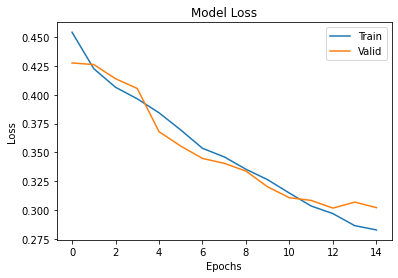

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

### 4.3 Model evaluation on validation set

In [21]:
pred = model.predict(X_train[-m:, :, :])
pred[:, :, 0].shape,

3/3 [==============================] - 1s 9ms/step


((80, 27),)

In [22]:
forecast_error = abs(pred[:, :, 0] -  y_train[-m:, :, 0]).mean()
mase = forecast_error / abs( y_train[-m:, :, 6]).mean()

print(f'Mean absolute scaled error = {round(mase.mean(), 4)}')

Mean absolute scaled error = 0.5157


### 4.4. Inference

In [23]:
pred_final = model.predict(X_test)

1/1 [==============================] - 0s 31ms/step


### 4.5. Inverse transformation of predictions

In [24]:
scaler = joblib.load('data/03_primary/scaler_js.joblib')

In [25]:
arr_pred = pred_final[:, :, 0]
y_pred = pd.DataFrame(arr_pred).T
y_pred_rescaled = scaler.inv_transform(y_pred)
y_pred_rescaled.shape

(27, 20)

### 4.6. Generation of the final result

In [26]:
predict_example = pd.read_parquet(PATH + 'data/01_raw/sample_submit.parquet.gzip')
print(f'test.shape = {predict_example.shape}\n')
predict_example.head(2)

test.shape = (540, 3)



,id,dt,target
0,0,2017-07-01,500
1,0,2017-07-02,500


In [27]:
n_shops = 20
for i in range(n_shops):
  predict_example.loc[predict_example['id'] == i, 'target'] = y_pred_rescaled.loc[:, i]

predict_example.to_parquet(
    'data/06_model_output/sales_forecast_lstm.parquet.gzip', compression='gzip'
)
predict_example.head()

,id,dt,target
0,0,2017-07-01,700.501168
1,0,2017-07-02,627.573811
2,0,2017-07-03,653.019479
3,0,2017-07-04,672.022311
4,0,2017-07-06,881.259424


## 5. Findings

* LSTM model has not generated the prominent results. However, model predictions are better than the naive forecast with sales for the previous month. 